In [1]:
# Standard library imports
import warnings
from collections import Counter
from datetime import datetime, timedelta

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from joblib import Parallel, delayed
from scipy.special import boxcox1p
from scipy.stats import boxcox, boxcox_normmax, skew, stats
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, 
                             precision_recall_fscore_support, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# Optuna specific imports
import optuna
from optuna.visualization import plot_optimization_history
from optuna.exceptions import TrialPruned


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
# Setting warnings to ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from collections import defaultdict


In [2]:
df=pd.read_csv('../data/BitcoinHeistDataPreProcessed.csv')

In [3]:
# The label Montreal is encoded as 0
# The label Panuda is encoded as 1
# The label Princeton is encoded as 2
# The label White is encoded as 3

# df1: designated attack (1)
# df2: other attacks (1)
# df3: white (0)

# Variable for designated attack
designated_attack = 2

# df1: designated attack (1)
df1 = df[df['label'] == designated_attack].copy()
df1['label'] = 1  # Transfer its original label to 1

# df2: other attacks (1)
df2 = df[(df['label'] != designated_attack) & (df['label'] != 3)].copy()
df2['label'] = 1  # Transfer other attacks’ label to 1

# df3: white (0)
df3 = df[df['label'] == 3].copy()

# Shuffle df3
df3 = df3.sample(frac=1, random_state=1)

# Calculate the number of samples for training and testing
num_train_samples = len(df2)
num_test_samples = len(df1)

# Split df3 into two parts for training and testing
df3_train = df3.iloc[:num_train_samples].copy()
#start at the row number equal to num_train_samples, and end at the row number equal to num_train_samples + num_test_samples".
df3_test = df3.iloc[num_train_samples:num_train_samples + num_test_samples].copy()

# Set the labels
df3_train['label'] = 0
df3_test['label'] = 0

# Create the training and testing dataframes
training_df = pd.concat([df2, df3_train])
test_df = pd.concat([df1, df3_test])

# For the training data
X_train = training_df.drop('label', axis=1)
y_train = training_df['label']

# For the test data
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
# #Montreal
# selected_features = ['address', 'year', 'day', 'length', 'neighbors', 'income',
#        'n_address_feature', 'day_of_week', 'average_income_per_transaction',
#        'transaction_count', 'merge_behavior', 'length_weight', 'week',
#        'total_volume', 'average_volume', 'transaction_frequency']

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# # Update the feature names to match the selected features
# selected_feature_names = X_train.columns
# print('Updated X_train with selected features: {}'.format(selected_feature_names))

# selected_feature_names = X_test.columns
# print('Updated X_test with selected features: {}'.format(selected_feature_names))

In [5]:
# #Padua
# selected_features = ['address', 'year', 'day', 'neighbors', 'income', 'n_address_feature',
#        'day_of_week', 'average_income_per_transaction', 'transaction_count',
#        'merge_behavior', 'week', 'total_volume', 'average_volume',
#        'transaction_frequency']

# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# # Update the feature names to match the selected features
# selected_feature_names = X_train.columns
# print('Updated X_train with selected features: {}'.format(selected_feature_names))

# selected_feature_names = X_test.columns
# print('Updated X_test with selected features: {}'.format(selected_feature_names))

In [6]:
# Princeton
selected_features = ['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Update the feature names to match the selected features
selected_feature_names = X_train.columns
print('Updated X_train with selected features: {}'.format(selected_feature_names))

selected_feature_names = X_test.columns
print('Updated X_test with selected features: {}'.format(selected_feature_names))

Updated X_train with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency'],
      dtype='object')
Updated X_test with selected features: Index(['address', 'year', 'day', 'length', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'total_volume', 'average_volume',
       'transaction_frequency'],
      dtype='object')


Accuracy: 0.5048833245936025
Prediction time: 0.007651090621948242 seconds
Precision: 0.5309544744765682
Recall: 0.5048833245936025
F1 score: 0.3728251097157228


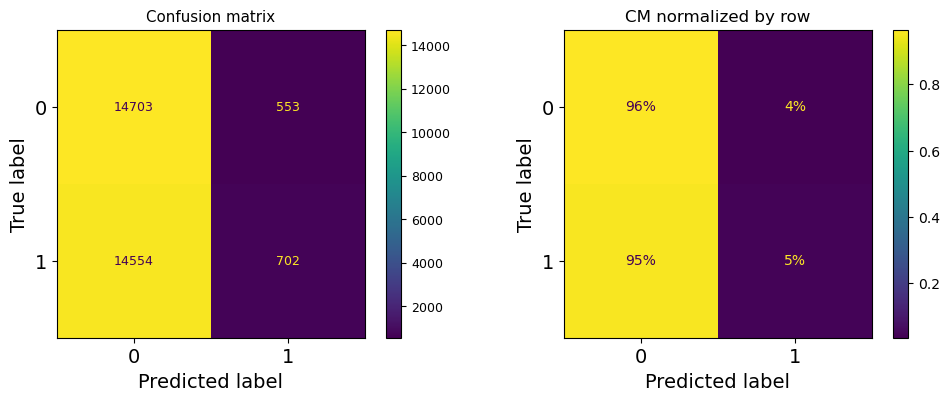

<Figure size 640x480 with 0 Axes>

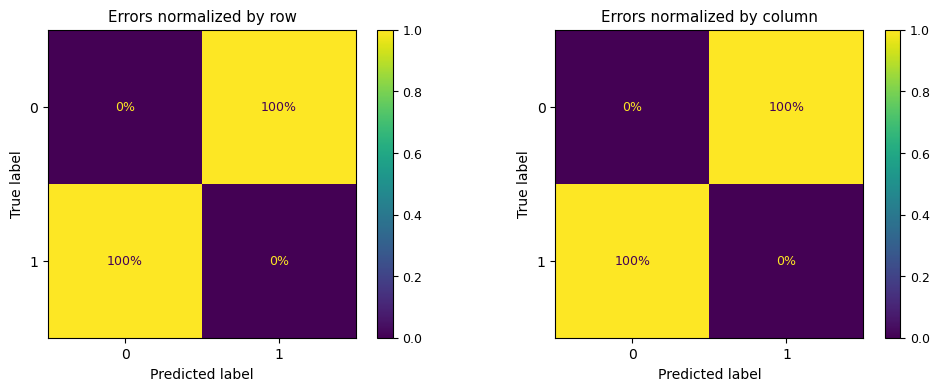

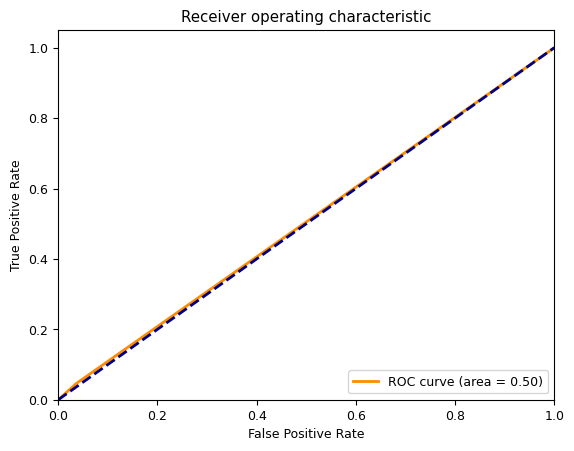

[CV 5/5] END base_score=0.99, booster=gbtree, learning_rate=0.2, max_depth=2, min_child_weight=3, n_estimators=1500;, score=0.606 total time=  11.7s
[CV 5/5] END base_score=0.75, booster=gbtree, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=500;, score=0.532 total time=  21.6s
[CV 5/5] END base_score=0.5, booster=gbtree, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=1500;, score=0.713 total time=  29.7s
[CV 3/5] END base_score=0.5, booster=gblinear, learning_rate=0.05, n_estimators=1500;, score=0.848 total time=   2.3s
[CV 5/5] END base_score=0.99, booster=gblinear, learning_rate=0.05, n_estimators=1100;, score=0.500 total time=   1.3s
[CV 5/5] END base_score=0.25, booster=gblinear, learning_rate=0.05, n_estimators=1100;, score=0.852 total time=   1.7s
[CV 1/5] END base_score=0.5, booster=gblinear, learning_rate=0.15, n_estimators=500;, score=0.852 total time=   0.8s
[CV 2/5] END base_score=0.99, booster=gbtree, learning_rate=0.2, max_depth=2, mi

[CV 5/5] END base_score=0.99, booster=gbtree, learning_rate=0.1, max_depth=2, min_child_weight=2, n_estimators=1100;, score=0.661 total time=   8.7s
[CV 4/5] END base_score=0.99, booster=gbtree, learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=500;, score=0.729 total time=   6.0s
[CV 4/5] END base_score=0.25, booster=gbtree, learning_rate=0.1, max_depth=2, min_child_weight=4, n_estimators=500;, score=0.804 total time=   4.2s
[CV 5/5] END base_score=0.99, booster=gbtree, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=500;, score=0.535 total time=   9.9s
[CV 5/5] END base_score=0.75, booster=gbtree, learning_rate=0.15, max_depth=10, min_child_weight=4, n_estimators=100;, score=0.512 total time=   4.2s
[CV 1/5] END base_score=0.5, booster=gbtree, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=1500;, score=0.661 total time=  29.7s
[CV 1/5] END base_score=0.99, booster=gblinear, learning_rate=0.1, n_estimators=500;, score=0.500 total time=

In [10]:
# Import the necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import numpy as np

# Instantiate the XGBClassifier
model = XGBClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time - start_time
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('XGBClassifier_Confusion_matrix_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('xgbclassifier_roc_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())  # Save the figure to PDF first
    plt.show()  # Then display the figure

plt.rc('font', size=14)  # make fonts great again


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 1100, 'learning_rate': 0.2, 'booster': 'gblinear', 'base_score': 0.25}
Accuracy: 0.4490364446775039
Prediction time: 0.006188154220581055 seconds
Precision: 0.28569849651602014
Recall: 0.4490364446775039
F1 score: 0.31933850773946376


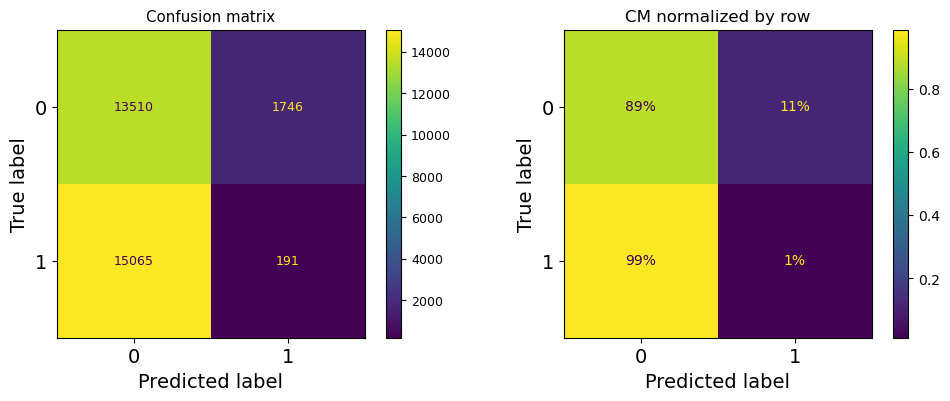

<Figure size 640x480 with 0 Axes>

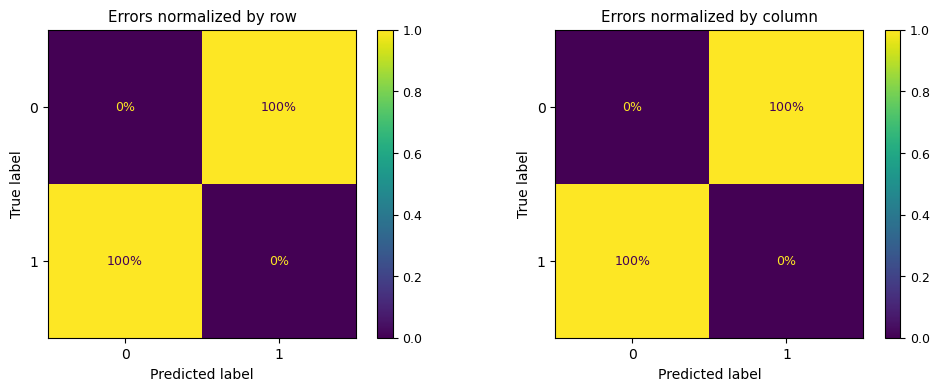

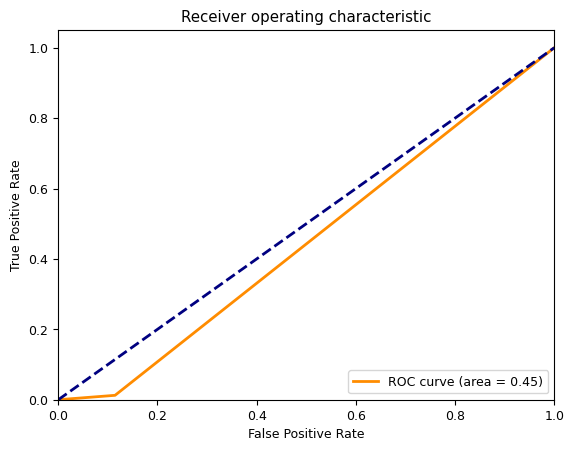

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time
import numpy as np

# Define the grid of hyperparameters to search for gbtree
hyperparameter_grid_gbtree = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth':[2, 3, 5, 10, 15],
    'learning_rate':[0.05,0.1,0.15,0.20],
    'min_child_weight':[1,2,3,4],
    'booster':['gbtree'],
    'base_score':[0.25,0.5,0.75,0.99] 
}

# Define the grid of hyperparameters to search for gblinear
hyperparameter_grid_gblinear = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'learning_rate':[0.05,0.1,0.15,0.20],
    'booster':['gblinear'],
    'base_score':[0.25,0.5,0.75,0.99] 
}

# Instantiate the XGBClassifier
model = XGBClassifier()

# Set up the random searches
random_cv_gbtree = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid_gbtree,
                               cv=5, 
                               n_jobs=-1,
                               verbose=5)

random_cv_gblinear = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid_gblinear,
                               cv=5, 
                               n_jobs=-1,
                               verbose=5)

# Fit both searches
random_cv_gbtree.fit(X_train, y_train)
random_cv_gblinear.fit(X_train, y_train)

# Compare best scores and select the best model
best_random_cv = random_cv_gbtree if random_cv_gbtree.best_score_ > random_cv_gblinear.best_score_ else random_cv_gblinear

# Get the best parameters
best_parameters = best_random_cv.best_params_

print(f"Best parameters: {best_parameters}")

# Re-fit the model with the best parameters from the search
model = XGBClassifier(n_estimators=best_parameters["n_estimators"],
                      max_depth=best_parameters.get("max_depth", None),
                      learning_rate=best_parameters["learning_rate"],
                      min_child_weight=best_parameters.get("min_child_weight", None),
                      booster=best_parameters["booster"],
                      base_score=best_parameters["base_score"])
model.fit(X_train, y_train)



# Make predictions on the test data
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
prediction_time = end_time - start_time
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_pred != y_test)

with PdfPages('XGBClassifier_Confusion_matrix_tuned_Princeton.pdf') as pdf:
    # Part 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0])
    axs[0].set_title("Confusion matrix")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%", ax=axs[1])
    axs[1].set_title("CM normalized by row")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

    plt.clf()  # clear the figure for the next plot

    # Part 2
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
    axs[0].set_title("Errors normalized by row")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
    axs[1].set_title("Errors normalized by column")
    plt.show()
    pdf.savefig(fig)  # saves the current figure into a pdf page

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
with PdfPages('xgbclassifier_roc_tuned_Princeton.pdf') as pdf:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    pdf.savefig(plt.gcf())  # Save the figure to PDF first
    plt.show()  # Then display the figure

plt.rc('font', size=14)  # make fonts great again
